In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 2000 # number of profiles
nvza = 2 # number of channels
nsza=1



In [3]:
# spatial slicing dimensions
s = 82 # output slice size
ts = 82 # input slice size 32


In [4]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
print(r.shape)
r=r.reshape((2000, 82, 2))
print(r.shape)


(2000, 82, 1, 2)
(2000, 82, 2)


In [5]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [6]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 1600 profiles
test_size: 400 profiles


In [7]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

NameError: name 'model' is not defined

In [8]:
import os
checkpoint_path = "training_all_bilstm_embedding/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------



ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 16
eps = 2000



def eval_model(train_image, test_image, train_label, test_label):
    input_layer = tf.keras.layers.Input(shape=(ts,2),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(64,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=82, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(64),input_length=128)(positions)
        # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(encoded)
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(bi)
    
    flat=tf.keras.layers.Flatten()(bi)

    output=tf.keras.layers.Dense(82, activation="linear")(flat)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])
    
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    
    
     # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,save_freq=5*bsize)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])#validation set(15%)/trainset(85%)=0.17647

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [11]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,400*4,ts,2))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,2))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 400  401  402 ... 1997 1998 1999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [12]:
import datetime
t1 = datetime.datetime.now()


In [13]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 2)]           0         
_________________________________________________________________
dense (Dense)                (None, 82, 64)            192       
_________________________________________________________________
tf.__operators__.add (TFOpLa (None, 82, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 82, 128)           66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 82, 128)           98816     
_________________________________________________________________
flatten (Flatten)            (None, 10496)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 82)                860754

75/75 [==============================] - 1s 20ms/step - loss: 4.3318 - mean_squared_error: 4.3318 - root_mean_squared_error: 2.0812 - val_loss: 5.3407 - val_mean_squared_error: 5.3407 - val_root_mean_squared_error: 2.3110
Epoch 18/2000
 4/75 [>.............................] - ETA: 1s - loss: 3.9496 - mean_squared_error: 3.9496 - root_mean_squared_error: 1.9873
Epoch 00018: saving model to training_all_bilstm_embedding\cp-0018.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 4.0288 - mean_squared_error: 4.0288 - root_mean_squared_error: 2.0072 - val_loss: 5.1076 - val_mean_squared_error: 5.1076 - val_root_mean_squared_error: 2.2600
Epoch 19/2000
10/75 [===>..........................] - ETA: 1s - loss: 3.7582 - mean_squared_error: 3.7582 - root_mean_squared_error: 1.9383
Epoch 00019: saving model to training_all_bilstm_embedding\cp-0019.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 3.7888 - mean_squared_error: 3.7888 - root_mean_squared_error: 1.946

75/75 [==============================] - 2s 22ms/step - loss: 1.5300 - mean_squared_error: 1.5300 - root_mean_squared_error: 1.2367 - val_loss: 2.9928 - val_mean_squared_error: 2.9928 - val_root_mean_squared_error: 1.7300
Epoch 37/2000
20/75 [=======>......................] - ETA: 0s - loss: 1.3867 - mean_squared_error: 1.3867 - root_mean_squared_error: 1.1774
Epoch 00037: saving model to training_all_bilstm_embedding\cp-0037.ckpt
75/75 [==============================] - 2s 22ms/step - loss: 1.4634 - mean_squared_error: 1.4634 - root_mean_squared_error: 1.2095 - val_loss: 2.9687 - val_mean_squared_error: 2.9687 - val_root_mean_squared_error: 1.7230
Epoch 38/2000
24/75 [========>.....................] - ETA: 0s - loss: 1.3606 - mean_squared_error: 1.3606 - root_mean_squared_error: 1.1664
Epoch 00038: saving model to training_all_bilstm_embedding\cp-0038.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 1.4074 - mean_squared_error: 1.4074 - root_mean_squared_error: 1.186

Epoch 56/2000
35/75 [=============>................] - ETA: 0s - loss: 0.7015 - mean_squared_error: 0.7015 - root_mean_squared_error: 0.8375
Epoch 00056: saving model to training_all_bilstm_embedding\cp-0056.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.7062 - mean_squared_error: 0.7062 - root_mean_squared_error: 0.8403 - val_loss: 2.7217 - val_mean_squared_error: 2.7217 - val_root_mean_squared_error: 1.6497
Epoch 57/2000
38/75 [==============>...............] - ETA: 0s - loss: 0.6205 - mean_squared_error: 0.6205 - root_mean_squared_error: 0.7876
Epoch 00057: saving model to training_all_bilstm_embedding\cp-0057.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.6469 - mean_squared_error: 0.6469 - root_mean_squared_error: 0.8040 - val_loss: 2.6846 - val_mean_squared_error: 2.6846 - val_root_mean_squared_error: 1.6385
Epoch 58/2000
44/75 [================>.............] - ETA: 0s - loss: 0.6192 - mean_squared_error: 0.6192 - root_mean_squared_err

48/75 [==================>...........] - ETA: 0s - loss: 0.2799 - mean_squared_error: 0.2799 - root_mean_squared_error: 0.5290
Epoch 00075: saving model to training_all_bilstm_embedding\cp-0075.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.2851 - mean_squared_error: 0.2851 - root_mean_squared_error: 0.5339 - val_loss: 2.8882 - val_mean_squared_error: 2.8882 - val_root_mean_squared_error: 1.6995
Epoch 76/2000
55/75 [=====================>........] - ETA: 0s - loss: 0.2561 - mean_squared_error: 0.2561 - root_mean_squared_error: 0.5060
Epoch 00076: saving model to training_all_bilstm_embedding\cp-0076.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.2594 - mean_squared_error: 0.2594 - root_mean_squared_error: 0.5093 - val_loss: 2.8715 - val_mean_squared_error: 2.8715 - val_root_mean_squared_error: 1.6946
Epoch 77/2000
60/75 [=======================>......] - ETA: 0s - loss: 0.2425 - mean_squared_error: 0.2425 - root_mean_squared_error: 0.4924
Epo

25/75 [=========>....................] - ETA: 0s - loss: 13.0227 - mean_squared_error: 13.0227 - root_mean_squared_error: 3.6086
Epoch 00006: saving model to training_all_bilstm_embedding\cp-0006.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 12.7316 - mean_squared_error: 12.7316 - root_mean_squared_error: 3.5679 - val_loss: 12.1335 - val_mean_squared_error: 12.1335 - val_root_mean_squared_error: 3.4833
Epoch 7/2000
30/75 [===========>..................] - ETA: 0s - loss: 11.1528 - mean_squared_error: 11.1528 - root_mean_squared_error: 3.3393
Epoch 00007: saving model to training_all_bilstm_embedding\cp-0007.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 10.9923 - mean_squared_error: 10.9923 - root_mean_squared_error: 3.3153 - val_loss: 11.0327 - val_mean_squared_error: 11.0327 - val_root_mean_squared_error: 3.3215
Epoch 8/2000
33/75 [============>.................] - ETA: 0s - loss: 9.8842 - mean_squared_error: 9.8842 - root_mean_squared_error: 

37/75 [=============>................] - ETA: 0s - loss: 2.5431 - mean_squared_error: 2.5431 - root_mean_squared_error: 1.5947
Epoch 00025: saving model to training_all_bilstm_embedding\cp-0025.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 2.5261 - mean_squared_error: 2.5261 - root_mean_squared_error: 1.5893 - val_loss: 3.4843 - val_mean_squared_error: 3.4843 - val_root_mean_squared_error: 1.8666
Epoch 26/2000
45/75 [=================>............] - ETA: 0s - loss: 2.2098 - mean_squared_error: 2.2098 - root_mean_squared_error: 1.4864
Epoch 00026: saving model to training_all_bilstm_embedding\cp-0026.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 2.2475 - mean_squared_error: 2.2475 - root_mean_squared_error: 1.4990 - val_loss: 3.4704 - val_mean_squared_error: 3.4704 - val_root_mean_squared_error: 1.8629
Epoch 27/2000
48/75 [==================>...........] - ETA: 0s - loss: 2.2674 - mean_squared_error: 2.2674 - root_mean_squared_error: 1.5057
Epo

75/75 [==============================] - 2s 21ms/step - loss: 1.0747 - mean_squared_error: 1.0747 - root_mean_squared_error: 1.0363 - val_loss: 2.6860 - val_mean_squared_error: 2.6860 - val_root_mean_squared_error: 1.6389
Epoch 45/2000
58/75 [======================>.......] - ETA: 0s - loss: 1.0370 - mean_squared_error: 1.0370 - root_mean_squared_error: 1.0183
Epoch 00045: saving model to training_all_bilstm_embedding\cp-0045.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 1.0447 - mean_squared_error: 1.0447 - root_mean_squared_error: 1.0220 - val_loss: 2.6211 - val_mean_squared_error: 2.6211 - val_root_mean_squared_error: 1.6190
Epoch 46/2000
65/75 [=========================>....] - ETA: 0s - loss: 0.9800 - mean_squared_error: 0.9800 - root_mean_squared_error: 0.9896
Epoch 00046: saving model to training_all_bilstm_embedding\cp-0046.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.9898 - mean_squared_error: 0.9898 - root_mean_squared_error: 0.994

Epoch 64/2000
72/75 [===========================>..] - ETA: 0s - loss: 0.4733 - mean_squared_error: 0.4733 - root_mean_squared_error: 0.6878
Epoch 00064: saving model to training_all_bilstm_embedding\cp-0064.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.4748 - mean_squared_error: 0.4748 - root_mean_squared_error: 0.6889 - val_loss: 2.6404 - val_mean_squared_error: 2.6404 - val_root_mean_squared_error: 1.6249
Epoch 65/2000
75/75 [==============================] - 1s 20ms/step - loss: 0.4556 - mean_squared_error: 0.4556 - root_mean_squared_error: 0.6749 - val_loss: 2.6090 - val_mean_squared_error: 2.6090 - val_root_mean_squared_error: 1.6152
Epoch 66/2000
 4/75 [>.............................] - ETA: 1s - loss: 0.4247 - mean_squared_error: 0.4247 - root_mean_squared_error: 0.6515
Epoch 00066: saving model to training_all_bilstm_embedding\cp-0066.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.4424 - mean_squared_error: 0.4424 - root_mean_square

18/75 [======>.......................] - ETA: 0s - loss: 17.5105 - mean_squared_error: 17.5105 - root_mean_squared_error: 4.1842
Epoch 00005: saving model to training_all_bilstm_embedding\cp-0005.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 17.0861 - mean_squared_error: 17.0861 - root_mean_squared_error: 4.1332 - val_loss: 15.1784 - val_mean_squared_error: 15.1784 - val_root_mean_squared_error: 3.8959
Epoch 6/2000
23/75 [========>.....................] - ETA: 0s - loss: 13.7591 - mean_squared_error: 13.7591 - root_mean_squared_error: 3.7093
Epoch 00006: saving model to training_all_bilstm_embedding\cp-0006.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 13.8399 - mean_squared_error: 13.8399 - root_mean_squared_error: 3.7202 - val_loss: 13.8243 - val_mean_squared_error: 13.8243 - val_root_mean_squared_error: 3.7181
Epoch 7/2000
29/75 [==========>...................] - ETA: 0s - loss: 12.1276 - mean_squared_error: 12.1276 - root_mean_squared_error

33/75 [============>.................] - ETA: 0s - loss: 2.4395 - mean_squared_error: 2.4395 - root_mean_squared_error: 1.5619
Epoch 00024: saving model to training_all_bilstm_embedding\cp-0024.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 2.4556 - mean_squared_error: 2.4556 - root_mean_squared_error: 1.5670 - val_loss: 3.5848 - val_mean_squared_error: 3.5848 - val_root_mean_squared_error: 1.8934
Epoch 25/2000
39/75 [==============>...............] - ETA: 0s - loss: 2.2720 - mean_squared_error: 2.2720 - root_mean_squared_error: 1.5071
Epoch 00025: saving model to training_all_bilstm_embedding\cp-0025.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 2.3305 - mean_squared_error: 2.3305 - root_mean_squared_error: 1.5263 - val_loss: 3.7556 - val_mean_squared_error: 3.7556 - val_root_mean_squared_error: 1.9379
Epoch 26/2000
43/75 [================>.............] - ETA: 0s - loss: 2.4570 - mean_squared_error: 2.4570 - root_mean_squared_error: 1.5672
Epo

50/75 [===================>..........] - ETA: 0s - loss: 1.0481 - mean_squared_error: 1.0481 - root_mean_squared_error: 1.0236
Epoch 00043: saving model to training_all_bilstm_embedding\cp-0043.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 1.0675 - mean_squared_error: 1.0675 - root_mean_squared_error: 1.0330 - val_loss: 2.6618 - val_mean_squared_error: 2.6618 - val_root_mean_squared_error: 1.6315
Epoch 44/2000
54/75 [====================>.........] - ETA: 0s - loss: 1.0428 - mean_squared_error: 1.0428 - root_mean_squared_error: 1.0211
Epoch 00044: saving model to training_all_bilstm_embedding\cp-0044.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 1.0504 - mean_squared_error: 1.0504 - root_mean_squared_error: 1.0249 - val_loss: 2.6416 - val_mean_squared_error: 2.6416 - val_root_mean_squared_error: 1.6253
Epoch 45/2000
58/75 [======================>.......] - ETA: 0s - loss: 1.0051 - mean_squared_error: 1.0051 - root_mean_squared_error: 1.0025 ETA

64/75 [========================>.....] - ETA: 0s - loss: 0.4996 - mean_squared_error: 0.4996 - root_mean_squared_error: 0.7068
Epoch 00062: saving model to training_all_bilstm_embedding\cp-0062.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.5025 - mean_squared_error: 0.5025 - root_mean_squared_error: 0.7088 - val_loss: 2.7025 - val_mean_squared_error: 2.7025 - val_root_mean_squared_error: 1.6439
Epoch 63/2000
68/75 [==========================>...] - ETA: 0s - loss: 0.4584 - mean_squared_error: 0.4584 - root_mean_squared_error: 0.6770
Epoch 00063: saving model to training_all_bilstm_embedding\cp-0063.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.4612 - mean_squared_error: 0.4612 - root_mean_squared_error: 0.6790 - val_loss: 2.6754 - val_mean_squared_error: 2.6754 - val_root_mean_squared_error: 1.6357
Epoch 64/2000
74/75 [============================>.] - ETA: 0s - loss: 0.4334 - mean_squared_error: 0.4334 - root_mean_squared_error: 0.6582
Epo

29/75 [==========>...................] - ETA: 0s - loss: 10.8463 - mean_squared_error: 10.8463 - root_mean_squared_error: 3.2933 ETA: 0s - loss: 10.8968 - mean_squared_error: 10.8968 - root_mean_squared_error
Epoch 00007: saving model to training_all_bilstm_embedding\cp-0007.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 10.8604 - mean_squared_error: 10.8604 - root_mean_squared_error: 3.2955 - val_loss: 10.6968 - val_mean_squared_error: 10.6968 - val_root_mean_squared_error: 3.2706
Epoch 8/2000
33/75 [============>.................] - ETA: 0s - loss: 9.1559 - mean_squared_error: 9.1559 - root_mean_squared_error: 3.0258
Epoch 00008: saving model to training_all_bilstm_embedding\cp-0008.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 9.1918 - mean_squared_error: 9.1918 - root_mean_squared_error: 3.0317 - val_loss: 11.5577 - val_mean_squared_error: 11.5577 - val_root_mean_squared_error: 3.3997
Epoch 9/2000
38/75 [==============>...............] - ETA

43/75 [================>.............] - ETA: 0s - loss: 1.9697 - mean_squared_error: 1.9697 - root_mean_squared_error: 1.4033
Epoch 00026: saving model to training_all_bilstm_embedding\cp-0026.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 2.0233 - mean_squared_error: 2.0233 - root_mean_squared_error: 1.4221 - val_loss: 3.1876 - val_mean_squared_error: 3.1876 - val_root_mean_squared_error: 1.7854
Epoch 27/2000
48/75 [==================>...........] - ETA: 0s - loss: 1.9443 - mean_squared_error: 1.9443 - root_mean_squared_error: 1.3943
Epoch 00027: saving model to training_all_bilstm_embedding\cp-0027.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 1.9768 - mean_squared_error: 1.9768 - root_mean_squared_error: 1.4058 - val_loss: 3.0676 - val_mean_squared_error: 3.0676 - val_root_mean_squared_error: 1.7515
Epoch 28/2000
53/75 [====================>.........] - ETA: 0s - loss: 1.8305 - mean_squared_error: 1.8305 - root_mean_squared_error: 1.3529
Epo

Epoch 00045: saving model to training_all_bilstm_embedding\cp-0045.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.8537 - mean_squared_error: 0.8537 - root_mean_squared_error: 0.9238 - val_loss: 2.3955 - val_mean_squared_error: 2.3955 - val_root_mean_squared_error: 1.5477
Epoch 46/2000
62/75 [=======================>......] - ETA: 0s - loss: 0.8333 - mean_squared_error: 0.8333 - root_mean_squared_error: 0.9127
Epoch 00046: saving model to training_all_bilstm_embedding\cp-0046.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.8420 - mean_squared_error: 0.8420 - root_mean_squared_error: 0.9174 - val_loss: 2.4192 - val_mean_squared_error: 2.4192 - val_root_mean_squared_error: 1.5554
Epoch 47/2000
69/75 [==========================>...] - ETA: 0s - loss: 0.7964 - mean_squared_error: 0.7964 - root_mean_squared_error: 0.8923
Epoch 00047: saving model to training_all_bilstm_embedding\cp-0047.ckpt
75/75 [==============================] - 2s 21ms/step - lo

Epoch 65/2000
75/75 [==============================] - 1s 20ms/step - loss: 0.3730 - mean_squared_error: 0.3730 - root_mean_squared_error: 0.6107 - val_loss: 2.5046 - val_mean_squared_error: 2.5046 - val_root_mean_squared_error: 1.5826
Epoch 66/2000
 5/75 [=>............................] - ETA: 1s - loss: 0.3619 - mean_squared_error: 0.3619 - root_mean_squared_error: 0.6016
Epoch 00066: saving model to training_all_bilstm_embedding\cp-0066.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.3627 - mean_squared_error: 0.3627 - root_mean_squared_error: 0.6022 - val_loss: 2.5602 - val_mean_squared_error: 2.5602 - val_root_mean_squared_error: 1.6001
Epoch 67/2000
 8/75 [==>...........................] - ETA: 1s - loss: 0.3283 - mean_squared_error: 0.3283 - root_mean_squared_error: 0.5730
Epoch 00067: saving model to training_all_bilstm_embedding\cp-0067.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.3441 - mean_squared_error: 0.3441 - root_mean_square

Epoch 9/2000
38/75 [==============>...............] - ETA: 0s - loss: 8.6781 - mean_squared_error: 8.6781 - root_mean_squared_error: 2.9457
Epoch 00009: saving model to training_all_bilstm_embedding\cp-0009.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 8.5385 - mean_squared_error: 8.5385 - root_mean_squared_error: 2.9219 - val_loss: 8.3717 - val_mean_squared_error: 8.3717 - val_root_mean_squared_error: 2.8934
Epoch 10/2000
44/75 [================>.............] - ETA: 0s - loss: 7.4378 - mean_squared_error: 7.4378 - root_mean_squared_error: 2.7271
Epoch 00010: saving model to training_all_bilstm_embedding\cp-0010.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 7.4946 - mean_squared_error: 7.4946 - root_mean_squared_error: 2.7375 - val_loss: 8.1960 - val_mean_squared_error: 8.1960 - val_root_mean_squared_error: 2.8629
Epoch 11/2000
49/75 [==================>...........] - ETA: 0s - loss: 6.9493 - mean_squared_error: 6.9493 - root_mean_squared_erro

54/75 [====================>.........] - ETA: 0s - loss: 2.0053 - mean_squared_error: 2.0053 - root_mean_squared_error: 1.4160
Epoch 00028: saving model to training_all_bilstm_embedding\cp-0028.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 2.0230 - mean_squared_error: 2.0230 - root_mean_squared_error: 1.4222 - val_loss: 2.8947 - val_mean_squared_error: 2.8947 - val_root_mean_squared_error: 1.7014
Epoch 29/2000
58/75 [======================>.......] - ETA: 0s - loss: 1.8804 - mean_squared_error: 1.8804 - root_mean_squared_error: 1.3712
Epoch 00029: saving model to training_all_bilstm_embedding\cp-0029.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 1.9103 - mean_squared_error: 1.9103 - root_mean_squared_error: 1.3819 - val_loss: 3.0379 - val_mean_squared_error: 3.0379 - val_root_mean_squared_error: 1.7429
Epoch 30/2000
62/75 [=======================>......] - ETA: 0s - loss: 1.8897 - mean_squared_error: 1.8897 - root_mean_squared_error: 1.3745
Epo

Epoch 00047: saving model to training_all_bilstm_embedding\cp-0047.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.9385 - mean_squared_error: 0.9385 - root_mean_squared_error: 0.9687 - val_loss: 2.3841 - val_mean_squared_error: 2.3841 - val_root_mean_squared_error: 1.5440
Epoch 48/2000
72/75 [===========================>..] - ETA: 0s - loss: 0.9312 - mean_squared_error: 0.9312 - root_mean_squared_error: 0.9648
Epoch 00048: saving model to training_all_bilstm_embedding\cp-0048.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.9331 - mean_squared_error: 0.9331 - root_mean_squared_error: 0.9658 - val_loss: 2.3500 - val_mean_squared_error: 2.3500 - val_root_mean_squared_error: 1.5330
Epoch 49/2000
75/75 [==============================] - 1s 20ms/step - loss: 0.8817 - mean_squared_error: 0.8817 - root_mean_squared_error: 0.9389 - val_loss: 2.3577 - val_mean_squared_error: 2.3577 - val_root_mean_squared_error: 1.5355
Epoch 50/2000
 5/75 [=>............

10/75 [===>..........................] - ETA: 1s - loss: 0.4960 - mean_squared_error: 0.4960 - root_mean_squared_error: 0.7040
Epoch 00067: saving model to training_all_bilstm_embedding\cp-0067.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.4923 - mean_squared_error: 0.4923 - root_mean_squared_error: 0.7015 - val_loss: 2.3413 - val_mean_squared_error: 2.3413 - val_root_mean_squared_error: 1.5301
Epoch 68/2000
14/75 [====>.........................] - ETA: 1s - loss: 0.4225 - mean_squared_error: 0.4225 - root_mean_squared_error: 0.6499
Epoch 00068: saving model to training_all_bilstm_embedding\cp-0068.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.4220 - mean_squared_error: 0.4220 - root_mean_squared_error: 0.6496 - val_loss: 2.3524 - val_mean_squared_error: 2.3524 - val_root_mean_squared_error: 1.5338
Epoch 69/2000
20/75 [=======>......................] - ETA: 0s - loss: 0.3572 - mean_squared_error: 0.3572 - root_mean_squared_error: 0.5977
Epo

In [14]:
t2 = datetime.datetime.now()
print('time taken:',t2 - t1)


time taken: 1:34:53.055752


In [15]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 2.4609 with standard deviation (0.1394)
Estimated RMSE 1.5681 with standard deviation (0.0448)


In [16]:
cv_scores

[2.4792046546936035,
 2.4422566890716553,
 2.646737575531006,
 2.218536376953125,
 2.5176868438720703]

In [17]:
cv_scores2

[1.5745489597320557,
 1.5627721548080444,
 1.6268796920776367,
 1.4894752502441406,
 1.5867221355438232]

The optimal number of epochs is 59


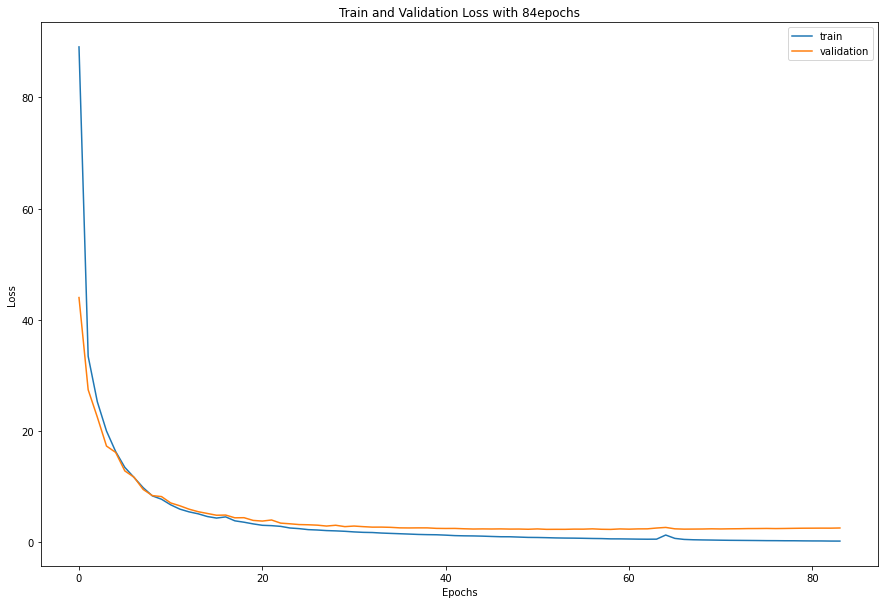

In [18]:
patience=25
plt.figure(figsize=(15,10))

# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [19]:
predict1=np.zeros(82) 
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

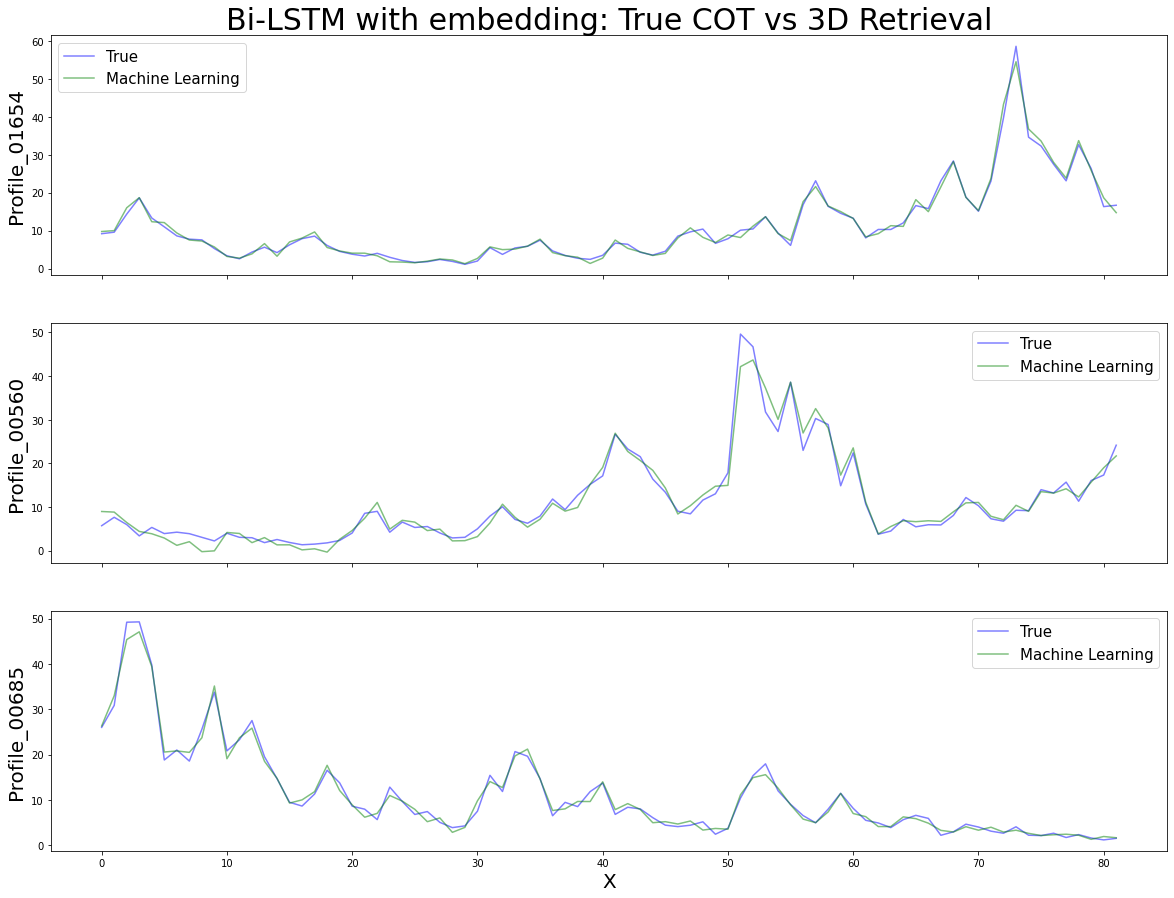

In [21]:
# plotting# ---------------------------------------------------------------------------------------------------
fgnm = "plots/Bi-LSTM with embedding "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with embedding: True COT vs 3D Retrieval",fontsize=30)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00560",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00685",fontsize=20)  
ax.set_xlabel('X',fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values¶

In [25]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(400):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)
std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 


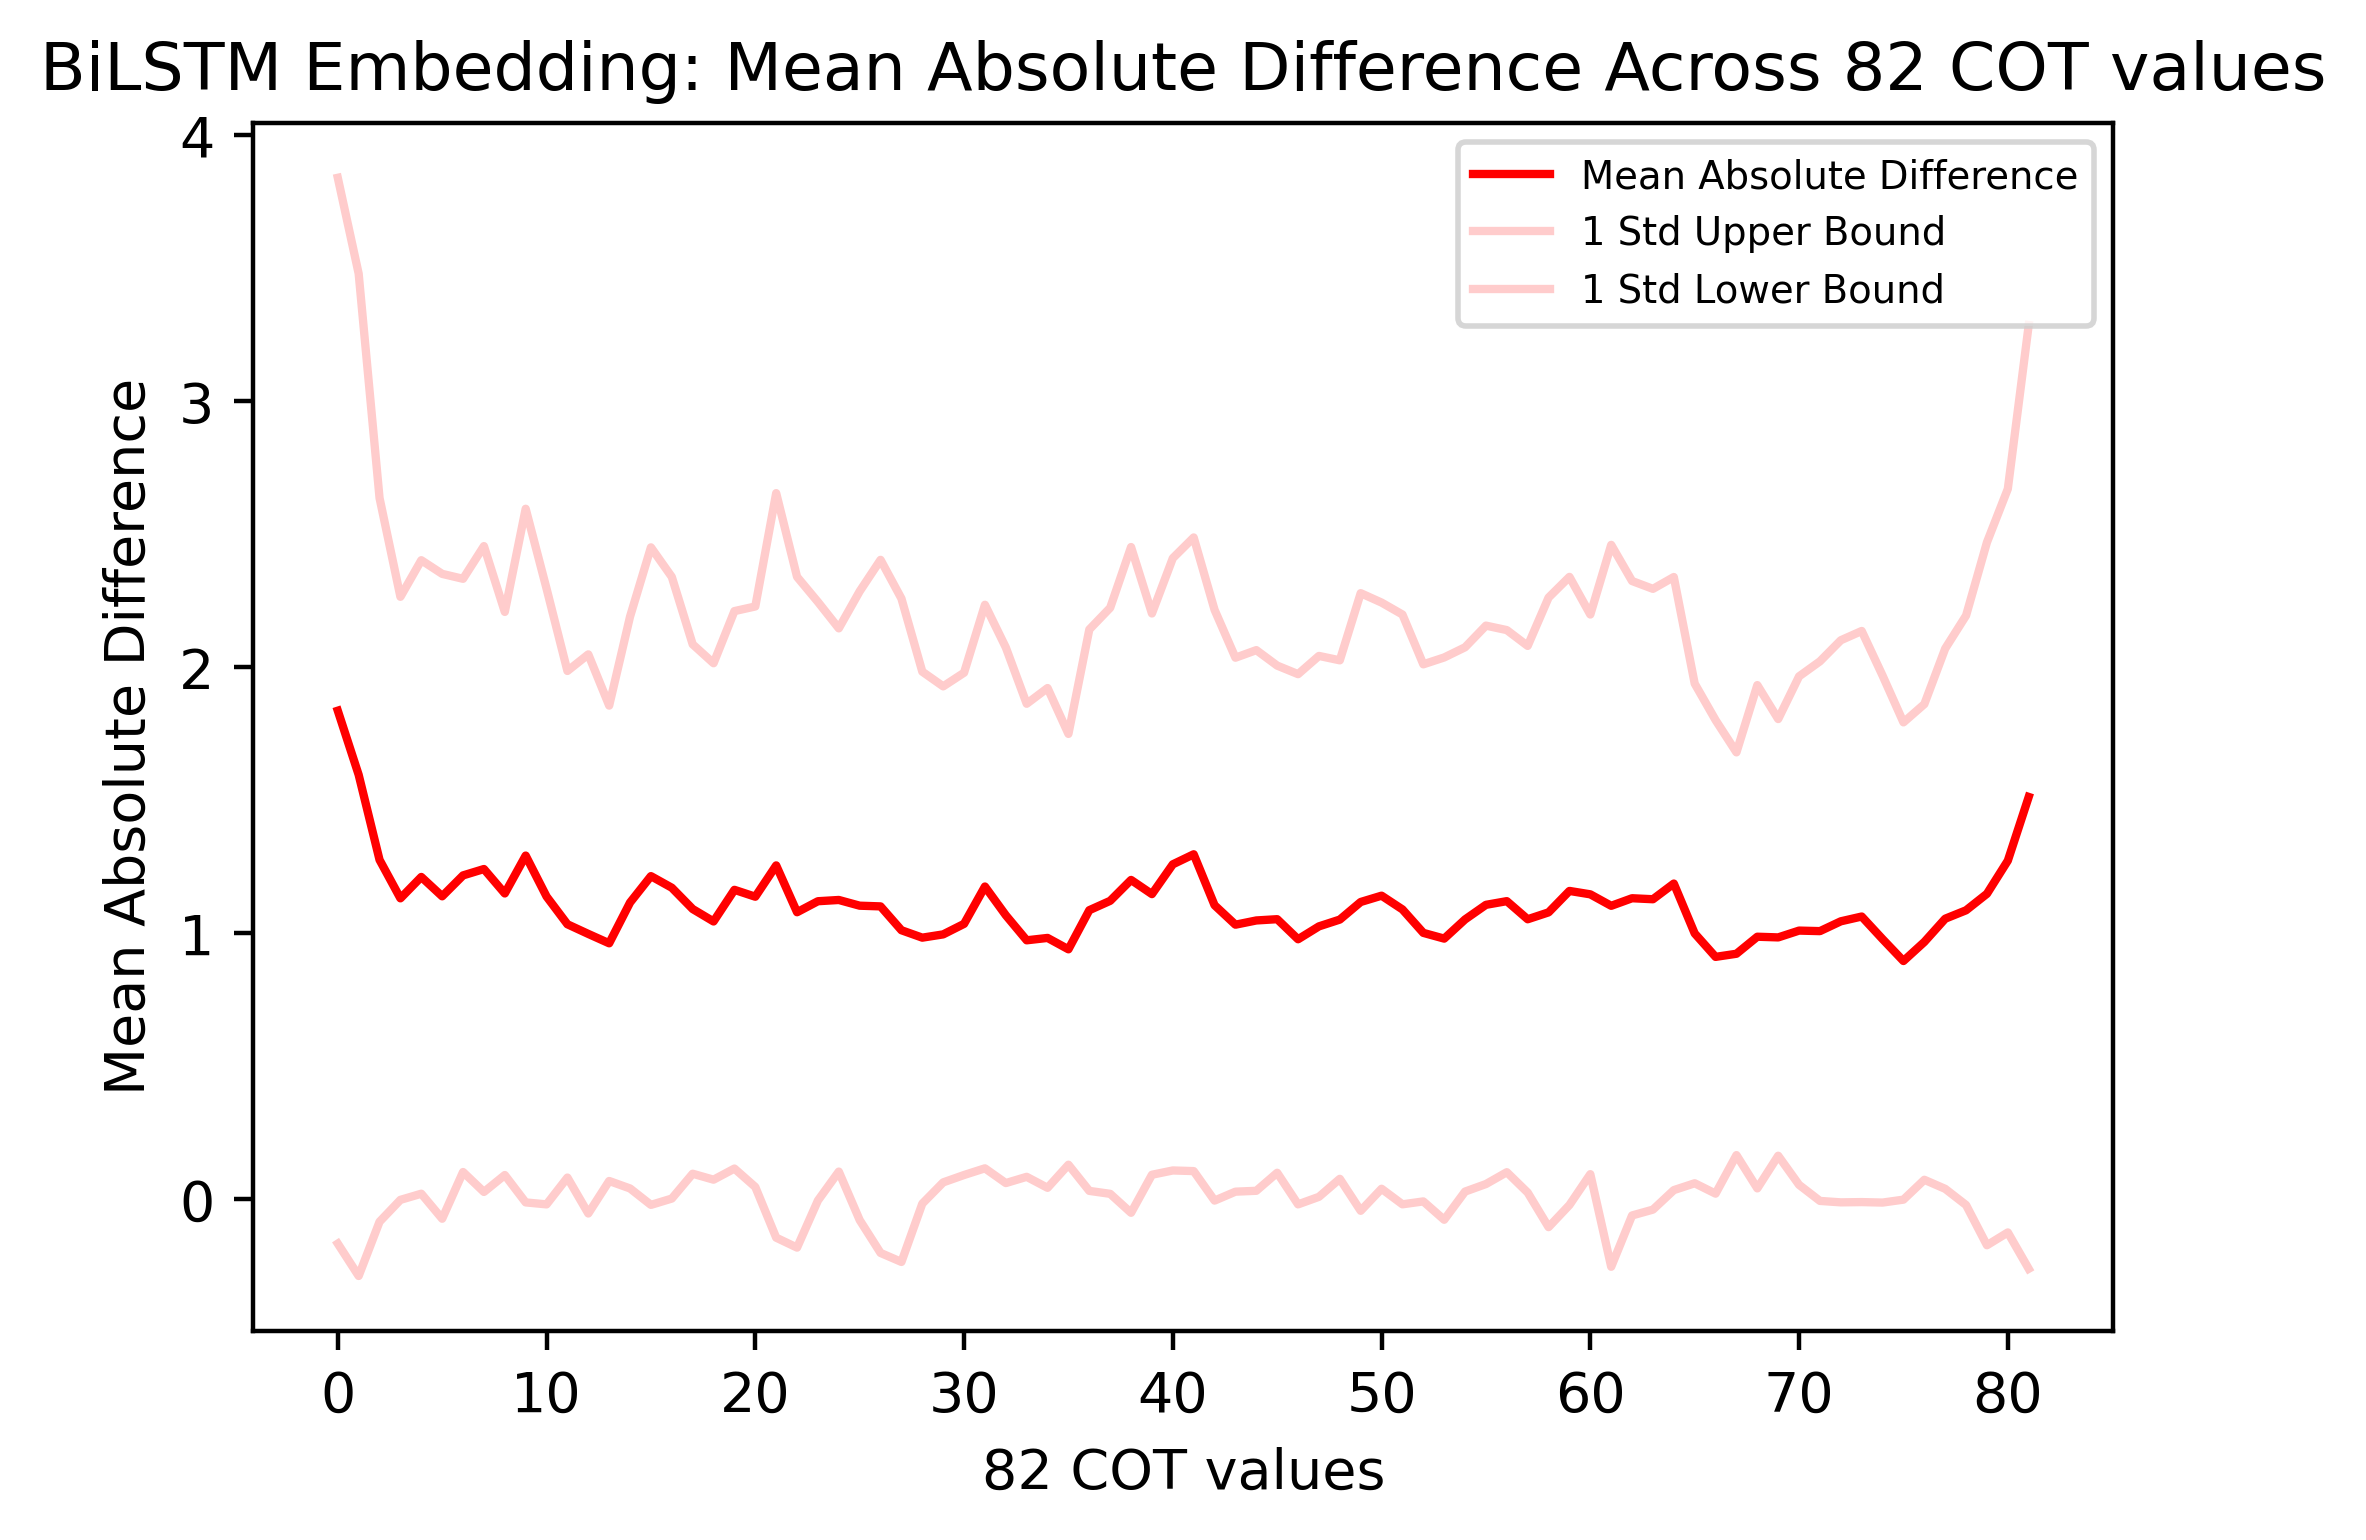

In [24]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

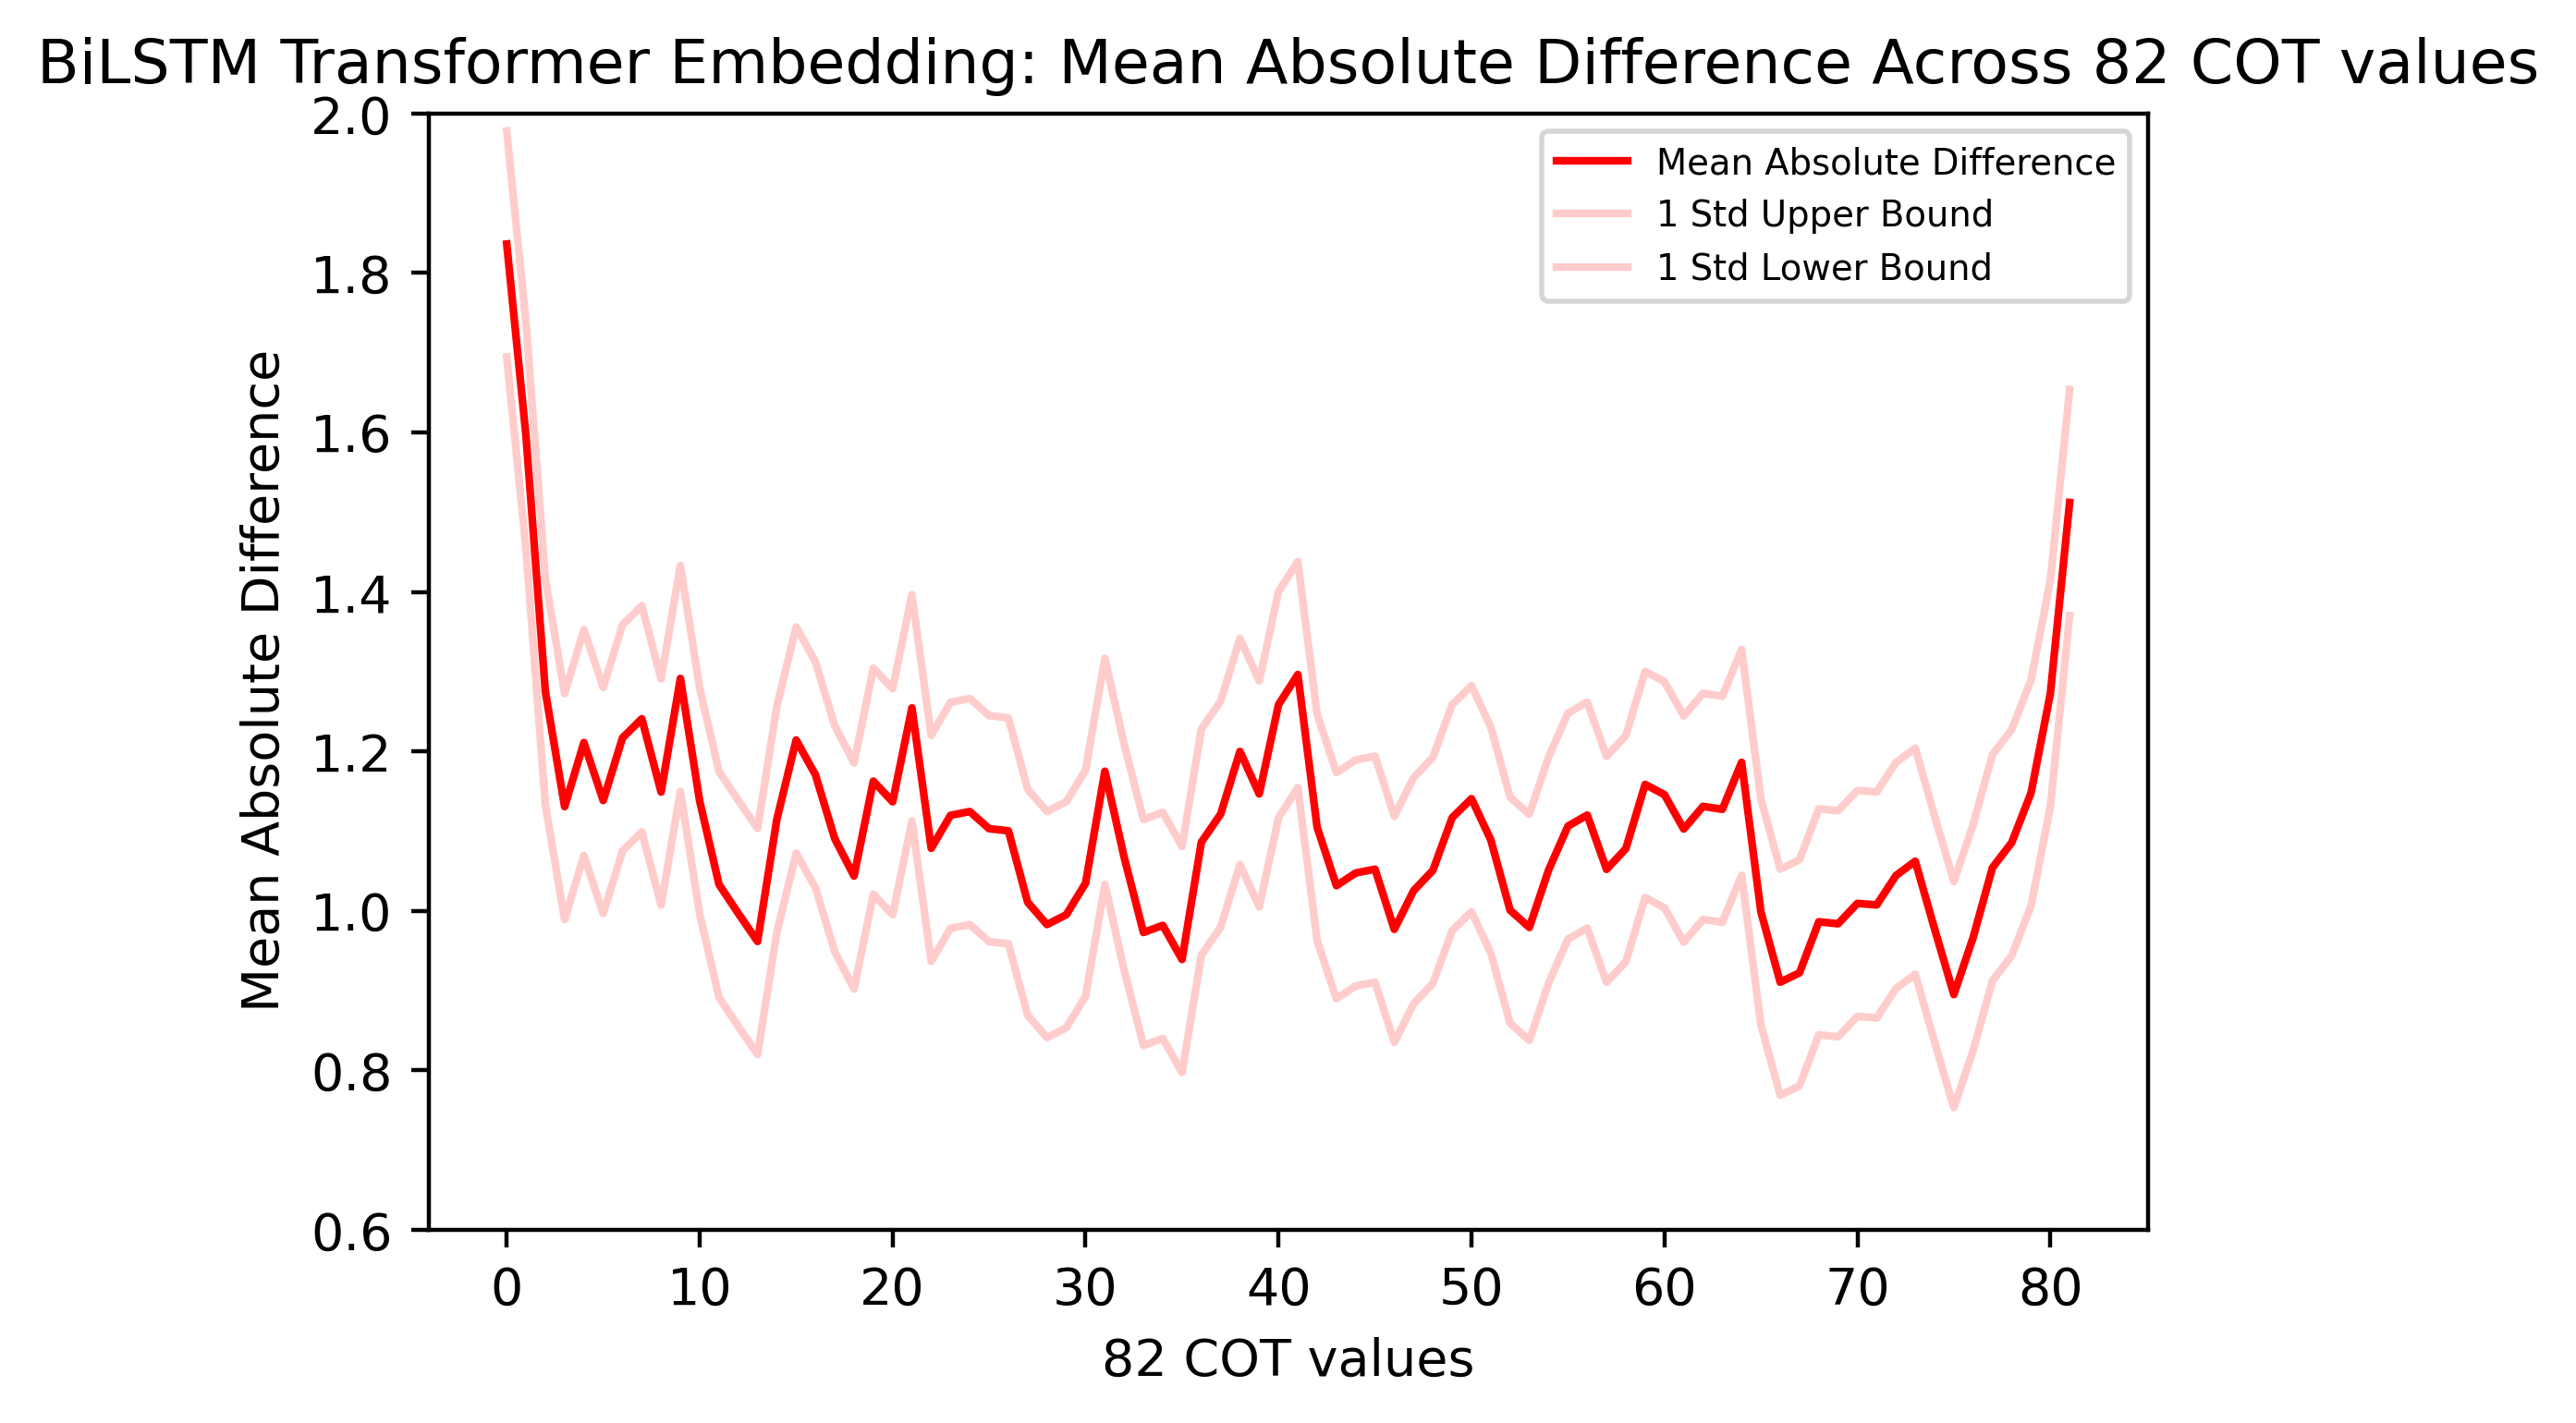

In [26]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0.6,2))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)